In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_path = '../data/curated/2016_11_sc.parquet'


In [ ]:
for year in range(2016, 2018+1):
    for month in [10, 11, 12]:
        

In [2]:
sub_df = pd.read_parquet(data_path)
sub_df

,PULocationID,DOLocationID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type,fare_amount,tip_amount,total_amount
0,48,143,2016-11-01 00:02:29,2016-11-01 00:08:06,1.40,1,6.5,1.55,9.35
1,239,41,2016-11-01 00:04:14,2016-11-01 00:11:35,2.10,1,9.0,2.05,12.35
2,41,42,2016-11-01 00:12:38,2016-11-01 00:15:58,1.00,2,5.5,0.00,6.80
3,239,151,2016-11-01 00:17:48,2016-11-01 00:20:28,0.90,2,4.5,0.00,5.80
4,186,90,2016-11-01 00:28:55,2016-11-01 00:31:23,0.60,1,4.0,1.05,6.35
...,...,...,...,...,...,...,...,...,...
10102123,41,116,2016-11-30 23:44:40,2016-11-30 23:51:16,1.72,2,7.5,0.00,8.80
10102124,137,114,2016-11-30 23:05:56,2016-11-30 23:14:43,1.99,2,8.5,0.00,9.80
10102125,137,265,2016-11-30 23:29:17,2016-12-01 23:14:43,17.35,1,49.0,13.96,69.80
10102126,142,237,2016-11-30 23:20:06,2016-11-30 23:27:19,1.24,2,7.0,0.00,8.30


In [3]:
sub_df.isnull().sum() 

PULocationID             0
DOLocationID             0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
trip_distance            0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
dtype: int64

In [ ]:
DAYS_IN_MONTH = [29, 31, 28, ]

date = f"{YEAR}-{MONTH}-{DAYS_IN_MONTH[MONTH]} 23:59:59"

In [4]:
### HANDWRITTEN THE STARTING AND ENDING DATETIME
# CHANGE TIME
sub_df = sub_df[(sub_df["tpep_pickup_datetime"] >= "2016-11-01 00:00:00")\
              & (sub_df["tpep_pickup_datetime"] <= "2016-11-30 23:59:59")]

In [5]:
# clean for trip distance 
sub_df = sub_df[sub_df.trip_distance > 0]
sub_df.shape

(10041049, 9)

In [6]:
# preprocess for payment type
sub_df["payment_type"].value_counts(ascending=True)

4      12988
3      38802
2    3368218
1    6621041
Name: payment_type, dtype: int64

In [7]:
sub_df = sub_df[(sub_df['payment_type'] == 1) | (sub_df['payment_type'] == 2)]

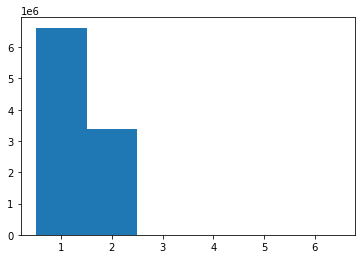

In [30]:
## plotting payment type distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(sub_df.payment_type, bins=6, range=(1, 7), align='left')
plt.show()
### Since the other three types do not meet 0.5% of population, we can basically ignore these data

In [31]:
# remove all data that does not follow normal payment trend (i.e. lower than basic fare amount or negative tip amount)
sub_df = sub_df[sub_df.fare_amount >= 2.5]
sub_df = sub_df[sub_df.tip_amount >= 0]
sub_df.shape

(9987801, 9)

In [32]:
# continuous cleaning by removing all suspicious human error points
# numbers are from 2018.11 cleaning, where I read all extreme large data and distinguish between large number and abnormal data
sub_df = sub_df[(sub_df.trip_distance <= 200) & (sub_df.fare_amount <= 500) & (sub_df.tip_amount <= 230) & (sub_df.total_amount <= 500) ]

In [33]:
sub_df.describe()

,PULocationID,DOLocationID,trip_distance,payment_type,fare_amount,tip_amount,total_amount
count,9.987801e+06,9.987801e+06,9.987801e+06,9.987801e+06,9.987801e+06,9.987801e+06,9.987801e+06
mean,1.634538e+02,1.611426e+02,2.966823e+00,1.337119e+00,1.324813e+01,1.840747e+00,1.652412e+01
std,6.676019e+01,7.055660e+01,3.713375e+00,4.727261e-01,1.105229e+01,2.538061e+00,1.372758e+01
min,1.000000e+00,1.000000e+00,1.000000e-02,1.000000e+00,2.500000e+00,0.000000e+00,2.800000e+00
25%,1.140000e+02,1.070000e+02,1.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,8.760000e+00
50%,1.620000e+02,1.620000e+02,1.700000e+00,1.000000e+00,9.500000e+00,1.350000e+00,1.230000e+01
75%,2.330000e+02,2.330000e+02,3.100000e+00,2.000000e+00,1.500000e+01,2.460000e+00,1.835000e+01
max,2.650000e+02,2.650000e+02,1.927000e+02,2.000000e+00,4.830000e+02,2.221400e+02,4.983000e+02


In [34]:
# Filling tips amounts for credit cash payment
# calculate average percentage of tip amount 
card_pmt = sub_df.loc[sub_df['payment_type'] == 1, ['tip_amount','total_amount']]
tip_rate = (card_pmt.tip_amount/card_pmt.total_amount).mean()
tip_rate

0.15370428731916366

In [35]:
sub_df.loc[sub_df['payment_type'] == 2, 'tip_amount'] = sub_df['total_amount'] * tip_rate

In [36]:
sub_df['cashtip'] = sub_df['tip_amount'] * (sub_df['payment_type']-1)
sub_df['total_adjusted_amount'] = sub_df['cashtip']+ sub_df['total_amount']
sub_df = sub_df.drop(['cashtip'], axis=1)
# Calculating income rate as income 
sub_df['income_rate'] = sub_df['total_adjusted_amount'] / sub_df['trip_distance']

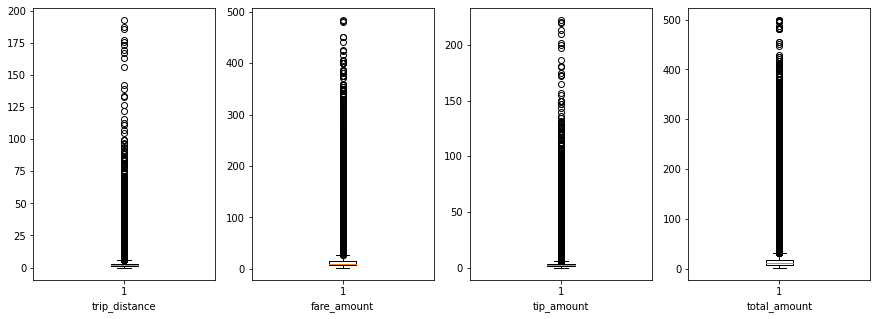

In [37]:
# boxplots after basic data cleaning
cols = ['trip_distance', 'fare_amount', 'tip_amount','total_amount']
fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].boxplot(sub_df[cols[i]])
    axs[i].set_xlabel(cols[i])
plt.show()

In [28]:
# quantile cleaning
cols = ['fare_amount', 'tip_amount','total_amount']
Q1 = sub_df[cols].quantile(0.25)
Q3 = sub_df[cols].quantile(0.75)
IQR = Q3 - Q1

In [29]:
# Remove outliers by 5IQR
removed_df = sub_df[((sub_df[cols] >= (Q1 - 5 * IQR)) & (sub_df[cols] <= (Q3 + 5 * IQR))).all(axis=1)]
removed_df.describe()

,PULocationID,DOLocationID,trip_distance,payment_type,fare_amount,tip_amount,total_amount
count,9.820591e+06,9.820591e+06,9.820591e+06,9.820591e+06,9.820591e+06,9.820591e+06,9.820591e+06
mean,1.637143e+02,1.615022e+02,2.715385e+00,1.341581e+00,1.248032e+01,1.668627e+00,1.548147e+01
std,6.694949e+01,7.029164e+01,3.111490e+00,4.742399e-01,9.073687e+00,1.983342e+00,1.088164e+01
min,1.000000e+00,1.000000e+00,1.000000e-02,1.000000e+00,2.500000e+00,0.000000e+00,2.800000e+00
25%,1.140000e+02,1.070000e+02,1.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,8.760000e+00
50%,1.620000e+02,1.620000e+02,1.650000e+00,1.000000e+00,9.500000e+00,1.260000e+00,1.225000e+01
75%,2.340000e+02,2.330000e+02,3.000000e+00,2.000000e+00,1.500000e+01,2.360000e+00,1.780000e+01
max,2.650000e+02,2.650000e+02,1.927000e+02,2.000000e+00,5.750000e+01,1.475000e+01,6.630000e+01


# boxplots after basic data cleaning
cols = ['trip_distance', 'fare_amount', 'tip_amount','total_amount']
fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].boxplot(removed_df[cols[i]])
    axs[i].set_xlabel(cols[i])
plt.show()

0.1531676387271018

In [14]:
removed_df.loc[removed_df['payment_type'] == 2, 'tip_amount'] = removed_df['total_amount'] * tip_rate

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [15]:
removed_df['cashtip'] = removed_df['tip_amount'] * (removed_df['payment_type']-1)
removed_df['total_adjusted_amount'] = removed_df['cashtip']+ removed_df['total_amount']
removed_df = removed_df.drop(['cashtip'], axis=1)
# Calculating income rate as income 
removed_df['income_rate'] = removed_df['total_adjusted_amount'] / removed_df['trip_distance']

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [16]:
# Calculating income rate as income 
removed_df['income_rate'] = removed_df['total_adjusted_amount'] / removed_df['trip_distance']

In [17]:
removed_df.describe()

,PULocationID,DOLocationID,trip_distance,payment_type,fare_amount,tip_amount,total_amount,cashtip,total_adjusted_amount,income_rate
count,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06,9.063589e+06
mean,1.648432e+02,1.627226e+02,2.003668e+00,1.345757e+00,1.041989e+01,1.981387e+00,1.295047e+01,5.885752e-01,1.353904e+01,8.901539e+00
std,6.776694e+01,7.027048e+01,1.537835e+00,4.756145e-01,5.202961e+00,1.083699e+00,6.024140e+00,9.397540e-01,6.163101e+00,1.309714e+01
min,1.000000e+00,1.000000e+00,1.000000e-02,1.000000e+00,2.500000e+00,0.000000e+00,2.800000e+00,0.000000e+00,3.000000e+00,6.417910e-02
25%,1.130000e+02,1.070000e+02,9.400000e-01,1.000000e+00,6.500000e+00,1.194708e+00,8.300000e+00,0.000000e+00,8.840000e+00,6.021818e+00
50%,1.620000e+02,1.620000e+02,1.510000e+00,1.000000e+00,9.000000e+00,1.760000e+00,1.130000e+01,0.000000e+00,1.187763e+01,7.725104e+00
75%,2.340000e+02,2.340000e+02,2.540000e+00,2.000000e+00,1.300000e+01,2.500000e+00,1.596000e+01,1.118124e+00,1.662000e+01,1.007407e+01
max,2.650000e+02,2.650000e+02,8.500000e+01,2.000000e+00,2.750000e+01,2.917690e+01,1.904900e+02,2.917690e+01,2.196669e+02,3.182743e+03


In [18]:
after_prep_df = removed_df[['PULocationID','DOLocationID','tpep_pickup_datetime','tpep_dropoff_datetime','total_adjusted_amount','income_rate']]

In [19]:
after_prep_df['PULocationID'].nunique()

256

In [20]:
date = after_prep_df['tpep_pickup_datetime'].dt.date

In [21]:
after_prep_df["date"] = date

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [22]:
after_prep_df.head()

,PULocationID,DOLocationID,tpep_pickup_datetime,tpep_dropoff_datetime,total_adjusted_amount,income_rate,date
0,48,143,2016-11-01 00:02:29,2016-11-01 00:08:06,9.350000,6.678571,2016-11-01
1,239,41,2016-11-01 00:04:14,2016-11-01 00:11:35,12.350000,5.880952,2016-11-01
2,41,42,2016-11-01 00:12:38,2016-11-01 00:15:58,7.841540,7.841540,2016-11-01
3,239,151,2016-11-01 00:17:48,2016-11-01 00:20:28,6.688372,7.431525,2016-11-01
4,186,90,2016-11-01 00:28:55,2016-11-01 00:31:23,6.350000,10.583333,2016-11-01


In [23]:
agg_df = after_prep_df.groupby(['PULocationID','date']).agg({'PULocationID':'first','income_rate':'mean','total_adjusted_amount':'mean'})
agg_df

PULocationID  income_rate  total_adjusted_amount
PULocationID date                                                        
1            2016-11-04             1    14.606790               4.382037
             2016-11-05             1     0.211414               3.805453
             2016-11-16             1     4.219653               7.300000
             2016-11-17             1    50.750000              20.300000
             2016-11-18             1     6.688372               6.688372
...                               ...          ...                    ...
265          2016-11-26           265     7.139333              15.028358
             2016-11-27           265    11.154505              11.324738
             2016-11-28           265    10.307388              17.142176
             2016-11-29           265    36.938424              15.221951
             2016-11-30           265     8.841077              12.978209

[6050 rows x 3 columns]

In [24]:
agg_df = agg_df.drop(['PULocationID'], axis=1)
agg_df = agg_df.reset_index()
agg_df

,PULocationID,date,income_rate,total_adjusted_amount
0,1,2016-11-04,14.606790,4.382037
1,1,2016-11-05,0.211414,3.805453
2,1,2016-11-16,4.219653,7.300000
3,1,2016-11-17,50.750000,20.300000
4,1,2016-11-18,6.688372,6.688372
...,...,...,...,...
6045,265,2016-11-26,7.139333,15.028358
6046,265,2016-11-27,11.154505,11.324738
6047,265,2016-11-28,10.307388,17.142176
6048,265,2016-11-29,36.938424,15.221951


In [112]:
# first create dataframe by running
agg_df.to_csv('../data/curated/'+'cleaned_data.csv')
# agg_df.to_csv('../data/curated/cleaned_data.csv', mode = 'a',header = False)

In [25]:
agg_df['income_rate'].describe()

count    6050.000000
mean        9.717915
std        26.416562
min         0.175367
25%         6.330358
50%         7.424410
75%         8.718435
max      1228.123535
Name: income_rate, dtype: float64